リードごとに計算した consensus unit(s) の類似度を使って overlap (filtering) を試みる。

In [56]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.display import display
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.io as pio
pio.templates.default = 'plotly_white'
import logging
import logzero
logzero.loglevel(logging.DEBUG)

In [2]:
dir_fname = 'work'
import os
os.chdir(dir_fname)

In [34]:
import numpy as np
from copy import copy
import pandas as pd
from BITS.clustering.seq import ClusteringSeq
from BITS.seq.align import EdlibRunner
from BITS.seq.consed import ConsedRunner
from BITS.util.io import save_pickle, load_pickle
from BITS.util.io import load_pickle, save_pickle
import numpy as np
import pandas as pd
from BITS.plot.plotly import make_hist, make_scatter, make_layout, show_plot
from BITS.clustering.seq import ClusteringSeq
import consed
from BITS.seq.align import EdlibRunner
from collections import Counter, defaultdict
from logzero import logger
from dataclasses import dataclass
from typing import List
import random
from copy import copy
from collections import Counter
from dataclasses import dataclass
from logzero import logger
import numpy as np
from vca.types import TRUnit
from BITS.clustering.seq import ClusteringSeq
from BITS.seq.align import EdlibRunner
from BITS.util.io import load_pickle, save_pickle
from BITS.util.proc import NoDaemonPool
from BITS.seq.utils import revcomp

In [18]:
def read_to_forward_units(read):
    """Return all units contained in <read> so that starnd of every unit is same as the forward master unit."""
    return [read.seq[unit.start:unit.end] if unit.id == 0 else revcomp(read.seq[unit.start:unit.end])
            for unit in read.units]

In [25]:
sync_reads = load_pickle("centromere_reads_incl_low_cover_rate_all_sync.pkl")

In [43]:
len(sync_reads)

1905

In [8]:
sync_units = []
for read in sync_reads:
    sync_units += read_to_forward_units(read)

In [9]:
len(sync_units)

46538

In [ ]:
centromere_phreds = load_pickle("centromere_phreds_incl_low_cover_rate_all_sync.pkl")

In [ ]:
sync_quals = []
for read in sync_reads:
    sync_quals += [centromere_phreds[read.name][unit.start:unit.end] if unit.id == 0
                   else np.flip(centromere_phreds[read.name][unit.start:unit.end])
                   for unit in read.units]

-> この数ではクラスタリングも厳しい。

In [4]:
db_prefix = "DMEL_CSS"
db_fname = f"{db_prefix}.db"
las_fname = f"TAN.{db_prefix}.las"
from vca import ReadViewer
v = ReadViewer(db_fname, las_fname)

In [26]:
sync_reads_by_id = {read.id: read for read in sync_reads}

In [29]:
v.show(read=sync_reads_by_id[73])

[I 190919 19:02:33 log:17] Starting distance matrix calculation 
[I 190919 19:02:33 log:19] Finished distance matrix calculation


In [28]:
sync_reads_by_id[762]

TRRead(seq='aaatccttcaaaaagtgatagtaatcgttagcgctggtaataagctgttaaaaaccgttattcttacatctatatgaccattttagccgagtaatgacgaaaattccgattgtaaatatcaacttttaggcaaaatccgtttttccaaatttcggtcatcaaataatcagttttttttttttgccacaactttataaatatttgtctgaatacggaatgtcatacttcgctgagctcgtaattacatttacaattaaaatgtgttcaaaaatggaaattatgtttttttgccatacttttcaaatttttatggggggtcattacaaaaaatacgaaaatttacccaaaaattgatttccctaaatccttcaataagtgatagtaatcgttagcgctggtaataagctgttaaaaaccgttattcttacatctatatgaccattttagccgagtaatgacgaaaattccgtttgtaaatatcaactttttggcaaaatccgtttttccaaatttcggtcatcaaataatcagttttttttttgccacaactttataaatatttgtctgaatacggaatgtcatacctcgctgagctcgtaattacatttaaaattaaaatgtgttcaaaaatggaaattatgttttttgccatactttgcaaatttttatggggggtcattacaaaaaatacgaaatttgacccaaatattgatttccctaaatccttcaaaaagtgatagtaatcgttagcgctggtaataagctgttaaaaaccgttattcttacatctatatgaccattttagccgagtaatgacgaaaattccgattgtaaatatcaacttttaggcaaaatccgttttttccaaatttcggtcatcaaataatcagtttttttttttttgccacaactttataaatatttgtctgaatacggaatgtcatacttcgctgagctcgtaattacatttacaattaaaatgtgttca

## Synchronized consensus unit(s)

Consed の結果は seed に非常に左右されやすいため、seed には master unit を使う。これによって、 difference between master and consensus == variant となる。

In [38]:
master_unit = "caaaaatgttgatatttacaaacgaaattttcgttataacttggctaaaaatggtcacatagatgtaagaataactgttttgagcagctaattaccagtgctaacgatccctattactttttgaaggatttagggaaattaatttttggatcaattttcgcattttttgtaaggaggggggtcatcaaaatttgcaaaatatggccaaaaaatttaatttccatttttgaacacagtttgattggaaattttattacgagctcagtgaggtatgacattccatattcagacaattattttttatgttgtggcaaaataaatgattatttgatgaccgaaatttggaaaaacagactctg"

In [39]:
def read_to_forward_consensus(read):
    logger.info(read.id)
    units = read_to_forward_units(read)
    if len(units) < 5:
        return ""
    return consed.consensus([master_unit] + units)   # master unit as seed

In [40]:
with NoDaemonPool(20) as pool:
    cons_units = pool.map(read_to_forward_consensus, sync_reads)

[I 190919 19:09:07 <ipython-input-39-5103e0bda2ac>:2] 73
[I 190919 19:09:07 <ipython-input-39-5103e0bda2ac>:2] 3571
[I 190919 19:09:07 <ipython-input-39-5103e0bda2ac>:2] 7333
[I 190919 19:09:07 <ipython-input-39-5103e0bda2ac>:2] 10305
[I 190919 19:09:07 <ipython-input-39-5103e0bda2ac>:2] 15230
[I 190919 19:09:07 <ipython-input-39-5103e0bda2ac>:2] 19539
[I 190919 19:09:07 <ipython-input-39-5103e0bda2ac>:2] 22783
[I 190919 19:09:07 <ipython-input-39-5103e0bda2ac>:2] 26555
[I 190919 19:09:07 <ipython-input-39-5103e0bda2ac>:2] 31865
[I 190919 19:09:07 <ipython-input-39-5103e0bda2ac>:2] 37430
[I 190919 19:09:07 <ipython-input-39-5103e0bda2ac>:2] 44025
[I 190919 19:09:07 <ipython-input-39-5103e0bda2ac>:2] 52012
[I 190919 19:09:07 <ipython-input-39-5103e0bda2ac>:2] 59001
[I 190919 19:09:07 <ipython-input-39-5103e0bda2ac>:2] 66043
[I 190919 19:09:07 <ipython-input-39-5103e0bda2ac>:2] 73985
[I 190919 19:09:07 <ipython-input-39-5103e0bda2ac>:2] 123
[I 190919 19:09:07 <ipython-input-39-5103e0bda2

[I 190919 19:09:07 <ipython-input-39-5103e0bda2ac>:2] 16818
[I 190919 19:09:07 <ipython-input-39-5103e0bda2ac>:2] 82247
[I 190919 19:09:07 <ipython-input-39-5103e0bda2ac>:2] 76048
[I 190919 19:09:07 <ipython-input-39-5103e0bda2ac>:2] 4194
[I 190919 19:09:07 <ipython-input-39-5103e0bda2ac>:2] 21342
[I 190919 19:09:07 <ipython-input-39-5103e0bda2ac>:2] 7758
[I 190919 19:09:07 <ipython-input-39-5103e0bda2ac>:2] 23402
[I 190919 19:09:07 <ipython-input-39-5103e0bda2ac>:2] 27940
[I 190919 19:09:07 <ipython-input-39-5103e0bda2ac>:2] 34592
[I 190919 19:09:07 <ipython-input-39-5103e0bda2ac>:2] 67720
[I 190919 19:09:07 <ipython-input-39-5103e0bda2ac>:2] 46573
[I 190919 19:09:07 <ipython-input-39-5103e0bda2ac>:2] 62454
[I 190919 19:09:07 <ipython-input-39-5103e0bda2ac>:2] 94167
[I 190919 19:09:07 <ipython-input-39-5103e0bda2ac>:2] 88847
[I 190919 19:09:08 <ipython-input-39-5103e0bda2ac>:2] 52749
[I 190919 19:09:08 <ipython-input-39-5103e0bda2ac>:2] 559
[I 190919 19:09:08 <ipython-input-39-5103e0b

[I 190919 19:09:08 <ipython-input-39-5103e0bda2ac>:2] 5298
[I 190919 19:09:08 <ipython-input-39-5103e0bda2ac>:2] 54680
[I 190919 19:09:08 <ipython-input-39-5103e0bda2ac>:2] 18025
[I 190919 19:09:08 <ipython-input-39-5103e0bda2ac>:2] 25482
[I 190919 19:09:08 <ipython-input-39-5103e0bda2ac>:2] 84544
[I 190919 19:09:08 <ipython-input-39-5103e0bda2ac>:2] 69907
[I 190919 19:09:08 <ipython-input-39-5103e0bda2ac>:2] 8877
[I 190919 19:09:08 <ipython-input-39-5103e0bda2ac>:2] 13406
[I 190919 19:09:08 <ipython-input-39-5103e0bda2ac>:2] 30002
[I 190919 19:09:08 <ipython-input-39-5103e0bda2ac>:2] 96358
[I 190919 19:09:08 <ipython-input-39-5103e0bda2ac>:2] 69925
[I 190919 19:09:08 <ipython-input-39-5103e0bda2ac>:2] 30473
[I 190919 19:09:08 <ipython-input-39-5103e0bda2ac>:2] 35838
[I 190919 19:09:08 <ipython-input-39-5103e0bda2ac>:2] 63982
[I 190919 19:09:08 <ipython-input-39-5103e0bda2ac>:2] 90639
[I 190919 19:09:08 <ipython-input-39-5103e0bda2ac>:2] 49959
[I 190919 19:09:08 <ipython-input-39-5103e

[I 190919 19:09:08 <ipython-input-39-5103e0bda2ac>:2] 109974
[I 190919 19:09:08 <ipython-input-39-5103e0bda2ac>:2] 102670
[I 190919 19:09:08 <ipython-input-39-5103e0bda2ac>:2] 64632
[I 190919 19:09:08 <ipython-input-39-5103e0bda2ac>:2] 22449
[I 190919 19:09:08 <ipython-input-39-5103e0bda2ac>:2] 80630
[I 190919 19:09:08 <ipython-input-39-5103e0bda2ac>:2] 6290
[I 190919 19:09:08 <ipython-input-39-5103e0bda2ac>:2] 56640
[I 190919 19:09:08 <ipython-input-39-5103e0bda2ac>:2] 96908
[I 190919 19:09:08 <ipython-input-39-5103e0bda2ac>:2] 73755
[I 190919 19:09:08 <ipython-input-39-5103e0bda2ac>:2] 14819
[I 190919 19:09:08 <ipython-input-39-5103e0bda2ac>:2] 118021
[I 190919 19:09:08 <ipython-input-39-5103e0bda2ac>:2] 90941
[I 190919 19:09:08 <ipython-input-39-5103e0bda2ac>:2] 25963
[I 190919 19:09:08 <ipython-input-39-5103e0bda2ac>:2] 26131
[I 190919 19:09:08 <ipython-input-39-5103e0bda2ac>:2] 26163
[I 190919 19:09:08 <ipython-input-39-5103e0bda2ac>:2] 31205
[I 190919 19:09:08 <ipython-input-39-5

[I 190919 19:09:09 <ipython-input-39-5103e0bda2ac>:2] 188716
[I 190919 19:09:09 <ipython-input-39-5103e0bda2ac>:2] 121355
[I 190919 19:09:09 <ipython-input-39-5103e0bda2ac>:2] 121493
[I 190919 19:09:09 <ipython-input-39-5103e0bda2ac>:2] 57607
[I 190919 19:09:09 <ipython-input-39-5103e0bda2ac>:2] 165883
[I 190919 19:09:09 <ipython-input-39-5103e0bda2ac>:2] 213896
[I 190919 19:09:09 <ipython-input-39-5103e0bda2ac>:2] 127099
[I 190919 19:09:09 <ipython-input-39-5103e0bda2ac>:2] 207519
[I 190919 19:09:09 <ipython-input-39-5103e0bda2ac>:2] 194574
[I 190919 19:09:09 <ipython-input-39-5103e0bda2ac>:2] 218279
[I 190919 19:09:09 <ipython-input-39-5103e0bda2ac>:2] 218436
[I 190919 19:09:09 <ipython-input-39-5103e0bda2ac>:2] 175852
[I 190919 19:09:09 <ipython-input-39-5103e0bda2ac>:2] 176753
[I 190919 19:09:09 <ipython-input-39-5103e0bda2ac>:2] 158064
[I 190919 19:09:09 <ipython-input-39-5103e0bda2ac>:2] 145538
[I 190919 19:09:09 <ipython-input-39-5103e0bda2ac>:2] 112597
[I 190919 19:09:09 <ipyth

[I 190919 19:09:09 <ipython-input-39-5103e0bda2ac>:2] 190796
[I 190919 19:09:09 <ipython-input-39-5103e0bda2ac>:2] 178194
[I 190919 19:09:09 <ipython-input-39-5103e0bda2ac>:2] 140563
[I 190919 19:09:09 <ipython-input-39-5103e0bda2ac>:2] 172455
[I 190919 19:09:09 <ipython-input-39-5103e0bda2ac>:2] 147159
[I 190919 19:09:09 <ipython-input-39-5103e0bda2ac>:2] 152202
[I 190919 19:09:09 <ipython-input-39-5103e0bda2ac>:2] 123347
[I 190919 19:09:09 <ipython-input-39-5103e0bda2ac>:2] 114576
[I 190919 19:09:09 <ipython-input-39-5103e0bda2ac>:2] 134771
[I 190919 19:09:09 <ipython-input-39-5103e0bda2ac>:2] 129277
[I 190919 19:09:09 <ipython-input-39-5103e0bda2ac>:2] 209944
[I 190919 19:09:09 <ipython-input-39-5103e0bda2ac>:2] 166857
[I 190919 19:09:09 <ipython-input-39-5103e0bda2ac>:2] 228721
[I 190919 19:09:09 <ipython-input-39-5103e0bda2ac>:2] 220030
[I 190919 19:09:09 <ipython-input-39-5103e0bda2ac>:2] 214831
[I 190919 19:09:09 <ipython-input-39-5103e0bda2ac>:2] 159704
[I 190919 19:09:09 <ipyt

[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 153997
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 216834
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 168175
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 168227
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 132499
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 230202
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 193036
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 211431
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 225554
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 125673
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 225601
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 204120
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 161674
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 198034
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 141704
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 221733
[I 190919 19:09:10 <ipyt

[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 245087
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 241011
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 250360
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 205420
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 232242
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 250548
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 205463
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 266087
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 227216
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 199109
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 271261
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 149670
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 261770
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 212448
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 255479
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 218140
[I 190919 19:09:10 <ipyt

[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 312933
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 328847
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 257618
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 329169
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 251307
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 267408
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 303690
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 308237
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 288032
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 297405
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 272397
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 292914
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 237348
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 237955
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 318426
[I 190919 19:09:10 <ipython-input-39-5103e0bda2ac>:2] 300269
[I 190919 19:09:10 <ipyt

[I 190919 19:09:11 <ipython-input-39-5103e0bda2ac>:2] 280573
[I 190919 19:09:11 <ipython-input-39-5103e0bda2ac>:2] 298104
[I 190919 19:09:11 <ipython-input-39-5103e0bda2ac>:2] 294180
[I 190919 19:09:11 <ipython-input-39-5103e0bda2ac>:2] 280611
[I 190919 19:09:11 <ipython-input-39-5103e0bda2ac>:2] 305314
[I 190919 19:09:11 <ipython-input-39-5103e0bda2ac>:2] 239823
[I 190919 19:09:11 <ipython-input-39-5103e0bda2ac>:2] 319082
[I 190919 19:09:11 <ipython-input-39-5103e0bda2ac>:2] 324263
[I 190919 19:09:11 <ipython-input-39-5103e0bda2ac>:2] 331281
[I 190919 19:09:11 <ipython-input-39-5103e0bda2ac>:2] 331596
[I 190919 19:09:11 <ipython-input-39-5103e0bda2ac>:2] 284308
[I 190919 19:09:11 <ipython-input-39-5103e0bda2ac>:2] 243543
[I 190919 19:09:11 <ipython-input-39-5103e0bda2ac>:2] 289820
[I 190919 19:09:11 <ipython-input-39-5103e0bda2ac>:2] 264069
[I 190919 19:09:11 <ipython-input-39-5103e0bda2ac>:2] 248307
[I 190919 19:09:11 <ipython-input-39-5103e0bda2ac>:2] 248365
[I 190919 19:09:11 <ipyt

[I 190919 19:09:11 <ipython-input-39-5103e0bda2ac>:2] 298370
[I 190919 19:09:11 <ipython-input-39-5103e0bda2ac>:2] 270222
[I 190919 19:09:11 <ipython-input-39-5103e0bda2ac>:2] 295111
[I 190919 19:09:11 <ipython-input-39-5103e0bda2ac>:2] 303008
[I 190919 19:09:11 <ipython-input-39-5103e0bda2ac>:2] 306786
[I 190919 19:09:11 <ipython-input-39-5103e0bda2ac>:2] 260767
[I 190919 19:09:11 <ipython-input-39-5103e0bda2ac>:2] 327007
[I 190919 19:09:11 <ipython-input-39-5103e0bda2ac>:2] 334300
[I 190919 19:09:11 <ipython-input-39-5103e0bda2ac>:2] 275793
[I 190919 19:09:11 <ipython-input-39-5103e0bda2ac>:2] 334590
[I 190919 19:09:11 <ipython-input-39-5103e0bda2ac>:2] 338589
[I 190919 19:09:11 <ipython-input-39-5103e0bda2ac>:2] 285801
[I 190919 19:09:11 <ipython-input-39-5103e0bda2ac>:2] 338605
[I 190919 19:09:11 <ipython-input-39-5103e0bda2ac>:2] 320118
[I 190919 19:09:11 <ipython-input-39-5103e0bda2ac>:2] 265626
[I 190919 19:09:11 <ipython-input-39-5103e0bda2ac>:2] 316639
[I 190919 19:09:11 <ipyt

[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 386669
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 391654
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 335853
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 365072
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 354265
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 349171
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 358790
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 381501
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 349410
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 399243
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 407035
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 370358
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 334084
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 413616
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 345149
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 418609
[I 190919 19:09:12 <ipyt

[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 366181
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 431820
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 415118
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 408790
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 400981
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 356006
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 356199
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 393886
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 345790
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 352095
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 352182
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 372094
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 382134
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 340785
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 378049
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 420395
[I 190919 19:09:12 <ipyt

[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 403064
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 367909
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 427803
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 433120
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 347462
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 403998
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 356921
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 384109
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 411062
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 342322
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 439131
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 353168
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 394585
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 389911
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 338272
[I 190919 19:09:12 <ipython-input-39-5103e0bda2ac>:2] 379417
[I 190919 19:09:12 <ipyt

[I 190919 19:09:13 <ipython-input-39-5103e0bda2ac>:2] 413222
[I 190919 19:09:13 <ipython-input-39-5103e0bda2ac>:2] 413347
[I 190919 19:09:13 <ipython-input-39-5103e0bda2ac>:2] 396395
[I 190919 19:09:13 <ipython-input-39-5103e0bda2ac>:2] 418280
[I 190919 19:09:13 <ipython-input-39-5103e0bda2ac>:2] 435011
[I 190919 19:09:13 <ipython-input-39-5103e0bda2ac>:2] 429479
[I 190919 19:09:13 <ipython-input-39-5103e0bda2ac>:2] 397565
[I 190919 19:09:13 <ipython-input-39-5103e0bda2ac>:2] 429598


In [41]:
cons_units = list(filter(lambda unit: unit != "", cons_units))

In [42]:
len(cons_units)

1665

300本くらいのリードでコンセンサスを取れなかった。

In [44]:
# master vs each cons unit
for cons_unit in cons_units:
    print(EdlibRunner("global", revcomp=False, cyclic=False).align(cons_unit, master_unit).cigar.flatten().string)

====================================================================X=================================================================D================================================================================================================================================================================================================================
==================================X====================================================================================================================================================================================================================================================================================================================================
======================================================================================================================================X=============X===================================================================================================================================

==================================X===================================================================================================D===X============================================================================================================================================================================================================================
======================================================================================================================================D=============================================D==============================================================================================================================================================X===================
======================================================================================================================================D===X=============================================================================================================================================

===================================================================================================================================================================================================X=============================================================================================================================================================DDDDDD
====================================================X=================================================================================D================================================================================================================================================================================================================================
====================================================================X===================================================================================================================================================================================================================

===================================================================X=====X============================================================D==============================================================================================================================================================================================X=================================
======================================================================================================================================D==============================================================================================================================================================================================X=================================
=======================X============================X=================================================================================D=================================================================================================================================================

この consensus unit をクラスタリングする。あくまで global feature なので overlap と等価ではない。

In [45]:
c = ClusteringSeq(cons_units, revcomp=False, cyclic=False)

In [46]:
c.calc_dist_mat(n_core=20)

[I 190919 19:13:13 log:17] Starting distance matrix calculation 
[I 190919 19:13:21 log:19] Finished distance matrix calculation


In [47]:
c.plot_tsne()

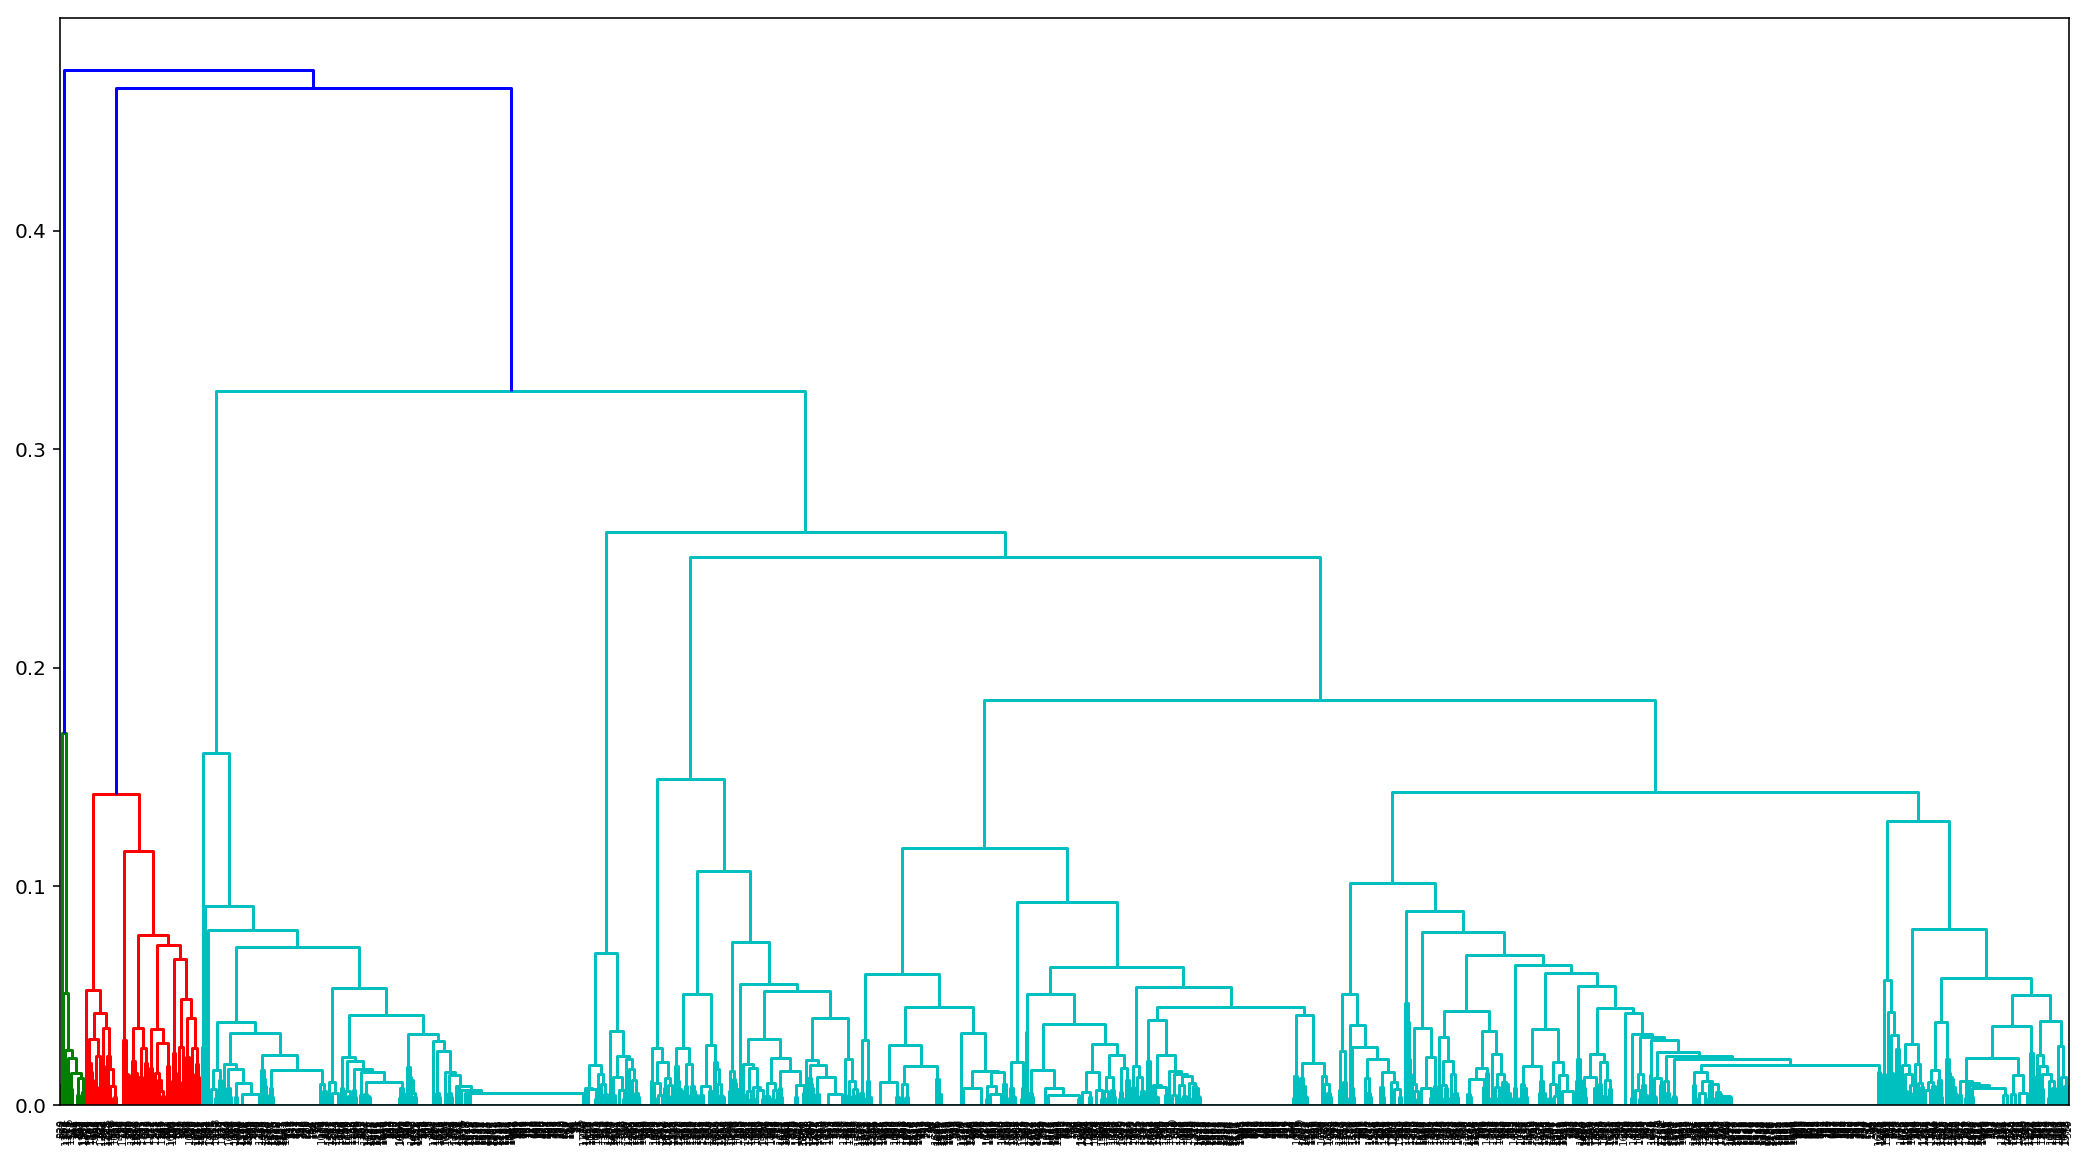

In [48]:
c.show_dendrogram()

In [49]:
c.cluster_hierarchical(threshold=0.15)

In [50]:
c.plot_tsne()

このコンセンサスを split-merge clustering するのは？

## Clustering of per-read consensus units with split-merge clustering

In [51]:
# Variants and sequencing errors

class PairwiseAlignment:
    def __init__(self, a_seq, b_seq):
        er = EdlibRunner("global", revcomp=False, cyclic=False)
        self.fcigar = er.align(b_seq.lower(), a_seq.lower()).cigar.flatten().string   # NOTE: b vs a; be careful!
        self.source, self.target = '', ''
        s_pos, t_pos = 0, 0
        for c in self.fcigar:
            if c == '=' or c == 'X':
                self.source += a_seq[s_pos]
                self.target += b_seq[t_pos]
                s_pos += 1
                t_pos += 1
            elif c == 'I':
                self.source += '-'
                self.target += b_seq[t_pos]
                t_pos += 1
            else:
                self.source += a_seq[s_pos]
                self.target += '-'
                s_pos += 1
        
    def show(self, by_cigar=False):
        if by_cigar:   # standard alignment like BLAST
            print(self.source)
            print(self.fcigar)
            print(self.target)
        else:
            print(''.join([' ' if c == '=' else self.source[i] for i, c in enumerate(self.fcigar)]))
            print(''.join([self.source[i] if c == '=' else ' ' for i, c in enumerate(self.fcigar)]))
            print(''.join([' ' if c == '=' else self.target[i] for i, c in enumerate(self.fcigar)]))

def count_variants(cluster_cons_unit, cluster_units):
    """Given a set of unit sequences <units> in a cluster, calculate the composition of
    nucleotides including '-' (= distribution of each )
    for each position on <cluster_cons_unit> as a seed.
    from which <units> are generated, compute the variations (= nucleotides inconsistent between
    <units> and <cluster_cons_unit> and their relative frequency).
    Since a cluster should be homogeneous (i.e., mono-source), the relative frequencies are
    expected to be not much larger than sequencing error.
    """
    assert cluster_cons_unit != "", "Empty strings are not allowed"
    # TODO: how to decide "same variant?" especially for multiple variations on same position (but slightly different among units)?
    variants = Counter()
    for unit in cluster_units:
        assert unit != "", "Empty strings are not allowed"
        alignment = PairwiseAlignment(cluster_cons_unit, unit)   # alignment.fcigar(cluster_cons_unit) = unit
        tpos = 0
        var_index = 0   # positive values for continuous insertions
        for i, c in enumerate(alignment.fcigar):
            if c == '=':
                var_index = 0
            elif c == 'I':
                var_index += 1
            if c != '=':
                variants[(tpos, var_index, c, alignment.target[i])] += 1   # TODO: multiple D on the same pos are aggregated
            if c != 'I':
                tpos += 1
        assert tpos == len(cluster_cons_unit)
    return variants

def list_variations(template_unit, cluster_cons_unit):
    """Single-vs-single version of count_variants().
    That is, list up the differences between the (imaginary) template unit and the consensus unit
    of a cluster (which should be a real instance).
    The return value is [(position_on_template_unit, variant_type, base_on_cluster_cons_unit)].
    """
    assert template_unit != "" and cluster_cons_unit != "", "Empty strings are not allowed"
    return list(count_variants(template_unit, [cluster_cons_unit]).keys())

In [52]:
# Probability of alignment 1) between units and 2) between a unit and a representative unit

def phred_to_log_p_correct(phred):
    return np.log10(1 - np.power(10, -phred / 10))

def phred_to_log_p_error(phred):
    return -phred / 10

def log_prob_gen(cons_unit, obs_unit, obs_qual=None, p_non_match=0.01):
    """Log likelihood of generating <obs_unit> from <cons_unit>.
    <obs_qual> is positional QVs of <obs_unit> and if not given,
    <p_non_match> is used as average error rate for every position.
    """
    if cons_unit == "":   # input sequences for <cons_unit> were empty; or, Consed did not return
        return -np.inf

    # Compute alignment
    er = EdlibRunner("global", revcomp=False)
    fcigar = er.align(cons_unit, obs_unit).cigar.flatten().string
    #logger.debug(fcigar)
    
    # Calculate the sum of log probabilities for each position in the alignment
    if obs_qual is None:
        n_match = Counter(fcigar)['=']
        n_non_match = len(fcigar) - n_match
        return n_match * np.log10(1 - p_non_match) + n_non_match * np.log10(p_non_match)
    else:
        p = 0.
        pos = 0
        for c in fcigar:
            p += (phred_to_log_p_correct(obs_qual[pos]) if c == '='
                  else phred_to_log_p_error(obs_qual[pos]))
            if c in ('=', 'X', 'D'):
                pos += 1
        assert pos == len(obs_unit) == len(obs_qual), "Invalid length"
        return p

def log_prob_align(unit_x, unit_y, qual_x=None, qual_y=None, p_error=0.01):
    """Log likelihood of alignment between <unit_x> from <unit_y>.
    <qual_*> is positional QVs of <unit_*> and if not given,
    <p_error> is used as average error rate for every position of each read.
    """
    # Compute alignment
    er = EdlibRunner("global", revcomp=False)
    fcigar = er.align(unit_x, unit_y).cigar.flatten().string
    #logger.debug(fcigar)
    
    # Calculate the sum of log probabilities for each position in the alignment
    if qual_x is None and qual_y is None:
        p_match = (1 - p_error) * (1 - p_error)
        n_match = Counter(fcigar)['=']
        n_non_match = len(fcigar) - n_match
        return n_match * np.log10(p_match) + n_non_match * np.log10(1 - p_match)
    else:
        p = 0.
        pos_x = pos_y = 0
        for c in fcigar:   # fcigar(unit_y) = unit_x
            p_match = phred_to_log_p_correct(qual_x[pos_x]) + phred_to_log_p_correct(qual_y[pos_y])
            p += (p_match if c == '='
                  else np.log10(1 - np.power(10, p_match)))
            if c in ('=', 'X', 'I'):
                pos_x += 1
            if c in ('=', 'X', 'D'):
                pos_y += 1
        assert pos_x == len(unit_x) == len(qual_x) and pos_y == len(unit_y) == len(qual_y), "Invalid length"
        return p
    
def log_factorial(n):
    return np.sum([np.log10(i) for i in range(1, n + 1)])
    
def log_prob_composition(cons_unit, obs_units, p_error=0.001):   # TODO: use positional QVs
    """Log likelihood of composition of <obs_units> given <cons_unit> as a seed; i.e., probability of alignment pileup.
    <p_error> is used for average sequencing error rate (= non-match rate in a single alignment).
    Concretely, compute Multinomial(n_A, ..., n_-; p_A, ..., p_-) for each position, where p_X = 1 - p_error
    if X is the base of <cons_unit>, otherwise p_X = p_error.
    """
    var_counts = count_variants(cons_unit, obs_units)
    var_pos = [pos for pos, index, op, base in var_counts.keys()]
    
    # compute for matches
    n_matches = len(cons_unit) - len(set(var_pos))
    p_match = n_matches * len(obs_units) * np.log10(1 - p_error)
    
    # compute for variants
    var_freqs = defaultdict(Counter)   # {(pos, index): Counter('A': n_A, ..., '-': n_-)} for each variant column
    for (pos, index, op, base), count in var_counts.items():   # list up frequencies of each variant for each position
        var_freqs[(pos, index)][base] = count
    log_factorial_N = log_factorial(len(obs_units))
    p_var = 0.
    for key, counts in var_freqs.items():   # for each variant position
        p_var += log_factorial_N
        for base, count in counts.items():
            p_var -= log_factorial(count)
            p_var += count * np.log10(p_error)
        n_match = len(obs_units) - np.sum(list(counts.values()))   # number of units having base same as seed
        p_var -= log_factorial(n_match)
        p_var += n_match * np.log10(1 - p_error)

    return p_match + p_var

In [71]:
def normalize_assignments(assignments):
    """Convert a clustering state <assignments> so that all essentially equal states can be
    same array. Return value type is Tuple so that it can be hashed as a dict key.
    """
    convert_table = {}
    new_id = 0
    for cluster_id in assignments:
        if cluster_id not in convert_table:
            convert_table[cluster_id] = new_id
            new_id += 1
    return tuple([convert_table[cluster_id] for cluster_id in assignments])

@dataclass(eq=False)
class SplitMergeClustering:
    units: List[str]
    quals: np.ndarray
    alpha: float
    
    def __post_init__(self):
        self.N = len(self.units)   # number of data
        self.assignments = np.zeros([self.N], dtype=np.int16)   # cluster assignments

        # Compute all-vs-all unit alignment likelihood
        #self.log_p_mat = np.zeros([self.N, self.N], dtype=np.float32)
        #for i in range(self.N):
        #    for j in range(i + 1, self.N):
        #        self.log_p_mat[i][j] = self.log_p_mat[j][i] = log_prob_align(self.units[i], self.units[j],
        #                                                                    self.quals[i], self.quals[j])
        
        # Cache for values computationally expensive
        self.cache_log_prob_clustering = {}   # {normalized_assignments: probability}
        self.cache_cluster_cons = {}   # {unit_ids: cluster_cons}
        
        # Pre-compute some constants
        self.const_ewens = -np.sum([np.log10(self.alpha + i) for i in range(self.N)])
        self.const_gibbs = -np.log10(self.N - 1 + self.alpha)
        
        # Compute consensus unit of the whole units so that comparing clusters can be easy
        self.template_unit = self.cluster_cons(0)
        
    def show_clustering(self):
        er = EdlibRunner("global", revcomp=False)
        for cluster_id in np.unique(self.assignments):
            print(f"Cluster {cluster_id} ({len(self.cluster_units(cluster_id))} units):\n"
                  f"{self.cluster_unit_ids(cluster_id)}\n"
                  f"{self.cluster_cons(cluster_id)}\n"
                  f"{er.align(self.cluster_cons(cluster_id), self.template_unit).cigar.flatten().string}")
            print("---")
            for unit in self.cluster_units(cluster_id):
                print(f"{er.align(unit, self.cluster_cons(cluster_id)).cigar.flatten().string}")
                
    def n_units(self, cluster_id, assignments=None, exclude_unit=None):
        """Return the number of units in the cluster <cluster_id> given a clustering state <assignments>,
        while excluding a unit <exclude_unit> if provided."""
        return len(self.cluster_unit_ids(cluster_id, assignments, exclude_unit))
            
    def cluster_unit_ids(self, cluster_id, assignments=None, exclude_unit=None):
        """Return indices of the units belonging to the cluster <cluster_id> given a clustering state <assignments>,
        while excluding a unit <exclude_unit> if provided."""
        return [i for i in range(self.N)
                if i != exclude_unit and (self.assignments if assignments is None else assignments)[i] == cluster_id]

    def cluster_units(self, cluster_id, assignments=None, exclude_unit=None):
        """Return unit sequences belonging to the cluster <cluster_id> given a clustering state <assignments>,
        while excluding a unit <exclude_unit> if provided."""
        return [self.units[i] for i in self.cluster_unit_ids(cluster_id, assignments, exclude_unit)]
    
    def n_clusters(self, assignments=None):
        """Return the number of clusters."""
        return len(self.cluster_ids(self.assignments if assignments is None else assignments))

    def cluster_ids(self, assignments=None):
        """Return a list of cluster indices."""
        return np.unique(self.assignments if assignments is None else assignments)

    def cluster_cons(self, cluster_id, assignments=None, exclude_unit=None):
        """Return the consensus sequence of the units belonging to the cluster <cluster_id> given a clustering state <assignments>,
        while excluding a unit <exclude_unit> if provided."""
        """
        # Check the cache
        cluster_units = set(self.cluster_units(cluster_id, assignments))
        excluded = False
        if exclude_unit is None or exclude_unit not in cluster_units:
            if tuple(sorted(cluster_units)) in self.cache_cluster_cons:
                return self.cache_cluster_cons[tuple(sorted(cluster_units))]
        else:
            cluster_units.remove(exclude_unit)
            excluded = True
        cluster_units = sorted(cluster_units)
        """

        cluster_units = self.cluster_units(cluster_id, assignments, exclude_unit)   # units belonging to the cluster
        

        if len(cluster_units) == 0:   # cluster with single unit which is excluded
            cons = ""
        elif len(cluster_units) == 1:   # cluster with single unit
            cons = cluster_units[0]   # TODO: NOTE: single data cluster can be harmful!
        else:
            cons = consed.consensus(cluster_units)
        
        #if not excluded:
        #    self.cache_cluster_cons[tuple(cluster_units)] = cons
        return cons
        
    def log_prob_ewens(self, assignments=None):
        """Return the probability of partition."""
        p = self.n_clusters() * np.log10(self.alpha)
        for cluster_id in self.cluster_ids(assignments):
            p += log_factorial(self.n_units(cluster_id, assignments) - 1)
        return p + self.const_ewens
    
    def log_prob_cluster_composition(self, cluster_id, assignments=None, p_error=0.001):
        """Return log probability of the composition of the cluster <cluster_id> given a clustering state <assignments>"""
        return log_prob_composition(self.cluster_cons(cluster_id, assignments),
                                    self.cluster_units(cluster_id, assignments))

    def log_prob_units_generation(self, cluster_id, assignments=None):
        """Return log probability of generating the units belonging to a cluster <cluster_id> from the cluster
        given a clustering state <assignments>."""
        cons = self.cluster_cons(cluster_id, assignments)
        return np.sum([log_prob_gen(cons, unit) for unit in self.cluster_units(cluster_id, assignments)])
        
    def log_prob_clustering(self, assignments=None):
        """Compute the joint probability of the current clustering state."""
        # Check the cache
        normalized_assignments = normalize_assignments(self.assignments if assignments is None else assignments)
        if normalized_assignments in self.cache_log_prob_clustering:
            logger.debug(f"Found in cache")
            return self.cache_log_prob_clustering[normalized_assignments]
        
        # First of all, check if consensus sequence exists for every cluster
        for cluster_id in self.cluster_ids(assignments):
            cons = self.cluster_cons(cluster_id, assignments)
            if cons == "":   # Consed did not return
                return -np.inf

        p_ewens = self.log_prob_ewens(assignments)
        p_cluster_compositions = np.sum([self.log_prob_cluster_composition(cluster_id, assignments)
                                         for cluster_id in self.cluster_ids(assignments)])
        p_gen_units = np.sum([self.log_prob_units_generation(cluster_id, assignments)
                              for cluster_id in self.cluster_ids(assignments)])

        p = p_ewens + p_cluster_compositions + p_gen_units
        self.cache_log_prob_clustering[normalized_assignments] = p
        return p
        
    def gibbs_sampling_single(self, unit_id, cluster_ids, assignments):
        """Compute probability of the unit assignment for each cluster while excluding the unit."""
        # NOTE: here assignment to a new cluster is not considered because of its very low probability
        #weights = tuple(map(lambda log_p: np.power(10, log_p),
        #                    [(np.log10(self.n_units(cluster_id, assignments, exclude_unit=unit_id))
        #                      - np.log10(self.N - 1 + self.alpha)
        #                      + log_prob_gen(self.cluster_cons(cluster_id, assignments, exclude_unit=unit_id),
        #                                  self.units[unit_id]))
        #                     for cluster_id in cluster_ids]))
        #new_assignment = random.choices(cluster_ids, weights=weights)[0]   # sample a new cluster assignment based on the probabilities
        #logger.debug(f"weights: {weights}, {assignments[unit_id]} -> {new_assignment}")
        #return new_assignment
        
        # NOTE: below is a proxy of Gibbs sampling; deterministically decide the nearest cluster as assignment
        max_prob = 0.
        max_cluster_id = -1
        for cluster_id in cluster_ids:
            log_p = (np.log10(self.n_units(cluster_id, assignments, exclude_unit=unit_id))
                     + self.const_gibbs
                     + log_prob_gen(self.cluster_cons(cluster_id, assignments, exclude_unit=unit_id),
                                    self.units[unit_id]))
            p = np.power(10, log_p)
            if p > max_prob:
                max_prob = p
                max_cluster_id = cluster_id
        return max_cluster_id

    def gibbs_sampling(self, unit_ids, cluster_ids, assignments, n_iter=1):
        """Re-assign each unit of <unit_ids> into one of the clusters <cluster_ids>,
        Given a clustering state <assignments>.
        """
        for t in range(n_iter):
            logger.debug(f"Round {t}")
            for unit_id in unit_ids:
                #logger.debug(assignments)
                old_assignment = assignments[unit_id]
                assignments[unit_id] = self.gibbs_sampling_single(unit_id, cluster_ids, assignments)
                new_assignment = assignments[unit_id]
                logger.debug(f"Unit {unit_id}: {old_assignment} -> {new_assignment}")
        return assignments
    
    def do_gibbs(self, n_iter=3):
        """Run a single iteration of Gibbs sampling with all units."""
        p_old = self.log_prob_clustering()
        self.assignments = self.gibbs_sampling(list(range(self.N)), self.cluster_ids(), self.assignments, n_iter)
        p_new = self.log_prob_clustering()
        logger.debug(f"State prob: {p_old} -> {p_new}")
        logger.debug(self.assignments)
    
    def do_proposal(self, n_iter=30):
        """Propose a new state by choosing random two units."""
        for t in range(n_iter):
            x, y = random.sample(list(range(self.N)), 2)
            logger.debug(f"Selected: {x}({self.assignments[x]}) and {y}({self.assignments[y]})")
            if self.assignments[x] == self.assignments[y]:
                logger.debug("Split")
                self.propose_split(x, y)
            else:
                logger.debug("Merge")
                self.propose_merge(x, y)

    def propose_split(self, x, y, n_gibbs_iter=2):
        # Split cluster <old_cluster_id> into <old_cluster_id> and <new_cluster_id>
        old_cluster_id = self.assignments[x]
        new_cluster_id = np.max(self.assignments) + 1
        new_assignments = np.copy(self.assignments)
        
        # Assign each unit to one of x and y randomly   # TODO: random assignment or nearest?
        new_assignments[y] = new_cluster_id
        for i in range(self.N):
            if i != x and i != y and new_assignments[i] == old_cluster_id:
                new_assignments[i] = random.choice((old_cluster_id, new_cluster_id))
                #if self.log_p_mat[i][x] < self.log_p_mat[i][y]:
                #    new_assignments[i] = new_cluster_id
        logger.debug(f"\nCurrent state:\n{self.assignments}\nProposed state (init):\n{new_assignments}")
        
        # Re-assign each unit to one of the new clusters (= Gibbs sampling)
        self.gibbs_sampling(self.cluster_unit_ids(old_cluster_id),
                            (old_cluster_id, new_cluster_id),
                            new_assignments, n_iter=n_gibbs_iter)
        logger.debug(f"\nCurrent state:\n{self.assignments}\nProposed state (Gibbs):\n{new_assignments}")
        
        # Compare the probability of the current state and the proposed state
        p_current = self.log_prob_clustering()
        p_new = self.log_prob_clustering(new_assignments)
        logger.debug(f"Current state prob: {p_current}, Proposed state prob: {p_new}")
        if p_current < p_new:
            logger.debug("Accepted")
            self.assignments = new_assignments
        else:
            logger.debug("Rejected")
            
    def propose_merge(self, x, y):
        # Merge two clusters if the consensus sequences are same   # TODO: allow some diff when noise exists?
        if self.cluster_cons(self.assignments[x]) == self.cluster_cons(self.assignments[y]):
            logger.debug("Accepted")
            for i in range(self.N):
                if self.assignments[i] == old_cluster_id_y:
                    self.assignments[i] = old_cluster_id_x
        else:
            logger.debug("Rejected")
        
        """
        # Merge cluster <old_cluster_id_x> and <old_cluster_id_y> into <old_cluster_id_x>
        old_cluster_id_x = self.assignments[x]
        old_cluster_id_y = self.assignments[y]
        new_assignments = np.copy(self.assignments)
        
        # Change cluster assignment of the units in the cluster which units[y] belongs to
        for i in range(self.N):
            if new_assignments[i] == old_cluster_id_y:
                new_assignments[i] = old_cluster_id_x
        logger.debug(f"\nCurrent state:\n{self.assignments}\nProposed state:\n{new_assignments}")
        
        # Compare the probability of the current state and the proposed state
        p_current = self.log_prob_clustering()
        p_new = self.log_prob_clustering(new_assignments)
        logger.debug(f"Current state prob: {p_current}, Proposed state prob: {p_new}")
        if p_current < p_new:
            logger.debug("Accepted")
            self.assignments = new_assignments
        else:
            logger.debug("Rejected")
        """

In [72]:
smc = SplitMergeClustering(cons_units, None, alpha=1)

In [75]:
smc.log_prob_clustering()

-20117.18576038825

In [74]:
smc.assignments = c.assignment

In [77]:
smc.do_proposal(1)

[D 190919 19:24:59 <ipython-input-71-9cac806f403a>:201] Selected: 707(9) and 1022(9)
[D 190919 19:24:59 <ipython-input-71-9cac806f403a>:203] Split
[D 190919 19:24:59 <ipython-input-71-9cac806f403a>:222] 
    Current state:
    [8 7 9 ... 9 9 8]
    Proposed state (init):
    [ 8  7  9 ...  9 10  8]
[D 190919 19:24:59 <ipython-input-71-9cac806f403a>:180] Round 0
[D 190919 19:25:00 <ipython-input-71-9cac806f403a>:186] Unit 2: 9 -> 9
[D 190919 19:25:00 <ipython-input-71-9cac806f403a>:186] Unit 4: 10 -> 9
[D 190919 19:25:00 <ipython-input-71-9cac806f403a>:186] Unit 13: 9 -> 9
[D 190919 19:25:00 <ipython-input-71-9cac806f403a>:186] Unit 15: 10 -> 9
[D 190919 19:25:00 <ipython-input-71-9cac806f403a>:186] Unit 17: 10 -> 9
[D 190919 19:25:01 <ipython-input-71-9cac806f403a>:186] Unit 18: 10 -> 9
[D 190919 19:25:01 <ipython-input-71-9cac806f403a>:186] Unit 20: 10 -> 9
[D 190919 19:25:01 <ipython-input-71-9cac806f403a>:186] Unit 26: 10 -> 9
[D 190919 19:25:01 <ipython-input-71-9cac806f403a>:186] 

[D 190919 19:25:20 <ipython-input-71-9cac806f403a>:186] Unit 278: 10 -> 9
[D 190919 19:25:21 <ipython-input-71-9cac806f403a>:186] Unit 283: 9 -> 9
[D 190919 19:25:21 <ipython-input-71-9cac806f403a>:186] Unit 286: 9 -> 9
[D 190919 19:25:21 <ipython-input-71-9cac806f403a>:186] Unit 293: 10 -> 9
[D 190919 19:25:21 <ipython-input-71-9cac806f403a>:186] Unit 299: 9 -> 9
[D 190919 19:25:21 <ipython-input-71-9cac806f403a>:186] Unit 302: 9 -> 9
[D 190919 19:25:22 <ipython-input-71-9cac806f403a>:186] Unit 308: 9 -> 9
[D 190919 19:25:22 <ipython-input-71-9cac806f403a>:186] Unit 309: 10 -> 9
[D 190919 19:25:22 <ipython-input-71-9cac806f403a>:186] Unit 318: 10 -> 9
[D 190919 19:25:22 <ipython-input-71-9cac806f403a>:186] Unit 320: 9 -> 9
[D 190919 19:25:22 <ipython-input-71-9cac806f403a>:186] Unit 322: 9 -> 9
[D 190919 19:25:23 <ipython-input-71-9cac806f403a>:186] Unit 327: 10 -> 9
[D 190919 19:25:23 <ipython-input-71-9cac806f403a>:186] Unit 329: 9 -> 9
[D 190919 19:25:23 <ipython-input-71-9cac806f4

[D 190919 19:25:42 <ipython-input-71-9cac806f403a>:186] Unit 588: 10 -> 9
[D 190919 19:25:42 <ipython-input-71-9cac806f403a>:186] Unit 591: 10 -> 9
[D 190919 19:25:42 <ipython-input-71-9cac806f403a>:186] Unit 592: 10 -> 9
[D 190919 19:25:42 <ipython-input-71-9cac806f403a>:186] Unit 595: 9 -> 9
[D 190919 19:25:43 <ipython-input-71-9cac806f403a>:186] Unit 597: 9 -> 9
[D 190919 19:25:43 <ipython-input-71-9cac806f403a>:186] Unit 600: 9 -> 9
[D 190919 19:25:43 <ipython-input-71-9cac806f403a>:186] Unit 601: 9 -> 9
[D 190919 19:25:43 <ipython-input-71-9cac806f403a>:186] Unit 608: 9 -> 9
[D 190919 19:25:43 <ipython-input-71-9cac806f403a>:186] Unit 612: 10 -> 9
[D 190919 19:25:44 <ipython-input-71-9cac806f403a>:186] Unit 613: 9 -> 9
[D 190919 19:25:44 <ipython-input-71-9cac806f403a>:186] Unit 616: 9 -> 9
[D 190919 19:25:44 <ipython-input-71-9cac806f403a>:186] Unit 618: 9 -> 9
[D 190919 19:25:44 <ipython-input-71-9cac806f403a>:186] Unit 622: 10 -> 9
[D 190919 19:25:44 <ipython-input-71-9cac806f4

[D 190919 19:26:03 <ipython-input-71-9cac806f403a>:186] Unit 903: 9 -> 9
[D 190919 19:26:04 <ipython-input-71-9cac806f403a>:186] Unit 905: 10 -> 9
[D 190919 19:26:04 <ipython-input-71-9cac806f403a>:186] Unit 907: 9 -> 9
[D 190919 19:26:04 <ipython-input-71-9cac806f403a>:186] Unit 915: 10 -> 9
[D 190919 19:26:04 <ipython-input-71-9cac806f403a>:186] Unit 916: 9 -> 9
[D 190919 19:26:04 <ipython-input-71-9cac806f403a>:186] Unit 917: 9 -> 9
[D 190919 19:26:05 <ipython-input-71-9cac806f403a>:186] Unit 922: 10 -> 9
[D 190919 19:26:05 <ipython-input-71-9cac806f403a>:186] Unit 925: 9 -> 9
[D 190919 19:26:05 <ipython-input-71-9cac806f403a>:186] Unit 927: 10 -> 9
[D 190919 19:26:05 <ipython-input-71-9cac806f403a>:186] Unit 930: 9 -> 9
[D 190919 19:26:05 <ipython-input-71-9cac806f403a>:186] Unit 932: 9 -> 9
[D 190919 19:26:05 <ipython-input-71-9cac806f403a>:186] Unit 938: 10 -> 9
[D 190919 19:26:06 <ipython-input-71-9cac806f403a>:186] Unit 942: 10 -> 9
[D 190919 19:26:06 <ipython-input-71-9cac806f

[D 190919 19:26:25 <ipython-input-71-9cac806f403a>:186] Unit 1229: 9 -> 9
[D 190919 19:26:25 <ipython-input-71-9cac806f403a>:186] Unit 1231: 10 -> 9
[D 190919 19:26:25 <ipython-input-71-9cac806f403a>:186] Unit 1238: 9 -> 9
[D 190919 19:26:25 <ipython-input-71-9cac806f403a>:186] Unit 1240: 10 -> 9
[D 190919 19:26:26 <ipython-input-71-9cac806f403a>:186] Unit 1241: 9 -> 9
[D 190919 19:26:26 <ipython-input-71-9cac806f403a>:186] Unit 1242: 9 -> 9
[D 190919 19:26:26 <ipython-input-71-9cac806f403a>:186] Unit 1244: 10 -> 9
[D 190919 19:26:26 <ipython-input-71-9cac806f403a>:186] Unit 1245: 9 -> 9
[D 190919 19:26:26 <ipython-input-71-9cac806f403a>:186] Unit 1249: 10 -> 9
[D 190919 19:26:27 <ipython-input-71-9cac806f403a>:186] Unit 1250: 10 -> 9
[D 190919 19:26:27 <ipython-input-71-9cac806f403a>:186] Unit 1252: 9 -> 9
[D 190919 19:26:27 <ipython-input-71-9cac806f403a>:186] Unit 1254: 9 -> 9
[D 190919 19:26:27 <ipython-input-71-9cac806f403a>:186] Unit 1260: 9 -> 9
[D 190919 19:26:27 <ipython-input

[D 190919 19:26:46 <ipython-input-71-9cac806f403a>:186] Unit 1538: 10 -> 9
[D 190919 19:26:47 <ipython-input-71-9cac806f403a>:186] Unit 1539: 9 -> 9
[D 190919 19:26:47 <ipython-input-71-9cac806f403a>:186] Unit 1540: 10 -> 9
[D 190919 19:26:47 <ipython-input-71-9cac806f403a>:186] Unit 1541: 9 -> 9
[D 190919 19:26:47 <ipython-input-71-9cac806f403a>:186] Unit 1542: 9 -> 9
[D 190919 19:26:47 <ipython-input-71-9cac806f403a>:186] Unit 1547: 10 -> 9
[D 190919 19:26:48 <ipython-input-71-9cac806f403a>:186] Unit 1548: 10 -> 9
[D 190919 19:26:48 <ipython-input-71-9cac806f403a>:186] Unit 1550: 9 -> 9
[D 190919 19:26:48 <ipython-input-71-9cac806f403a>:186] Unit 1552: 10 -> 9
[D 190919 19:26:48 <ipython-input-71-9cac806f403a>:186] Unit 1555: 9 -> 9
[D 190919 19:26:48 <ipython-input-71-9cac806f403a>:186] Unit 1558: 10 -> 9
[D 190919 19:26:49 <ipython-input-71-9cac806f403a>:186] Unit 1559: 10 -> 9
[D 190919 19:26:49 <ipython-input-71-9cac806f403a>:186] Unit 1560: 10 -> 9
[D 190919 19:26:49 <ipython-in

[D 190919 19:27:03 <ipython-input-71-9cac806f403a>:186] Unit 165: 9 -> 9
[D 190919 19:27:03 <ipython-input-71-9cac806f403a>:186] Unit 168: 9 -> 9
[D 190919 19:27:04 <ipython-input-71-9cac806f403a>:186] Unit 170: 9 -> 9
[D 190919 19:27:04 <ipython-input-71-9cac806f403a>:186] Unit 171: 9 -> 9
[D 190919 19:27:04 <ipython-input-71-9cac806f403a>:186] Unit 172: 9 -> 9
[D 190919 19:27:04 <ipython-input-71-9cac806f403a>:186] Unit 176: 9 -> 9
[D 190919 19:27:04 <ipython-input-71-9cac806f403a>:186] Unit 177: 9 -> 9
[D 190919 19:27:04 <ipython-input-71-9cac806f403a>:186] Unit 181: 9 -> 9
[D 190919 19:27:04 <ipython-input-71-9cac806f403a>:186] Unit 185: 9 -> 9
[D 190919 19:27:04 <ipython-input-71-9cac806f403a>:186] Unit 186: 9 -> 9
[D 190919 19:27:04 <ipython-input-71-9cac806f403a>:186] Unit 189: 9 -> 9
[D 190919 19:27:05 <ipython-input-71-9cac806f403a>:186] Unit 192: 9 -> 9
[D 190919 19:27:05 <ipython-input-71-9cac806f403a>:186] Unit 195: 9 -> 9
[D 190919 19:27:05 <ipython-input-71-9cac806f403a>:

[D 190919 19:27:17 <ipython-input-71-9cac806f403a>:186] Unit 475: 9 -> 9
[D 190919 19:27:17 <ipython-input-71-9cac806f403a>:186] Unit 476: 9 -> 9
[D 190919 19:27:17 <ipython-input-71-9cac806f403a>:186] Unit 478: 9 -> 9
[D 190919 19:27:17 <ipython-input-71-9cac806f403a>:186] Unit 482: 9 -> 9
[D 190919 19:27:18 <ipython-input-71-9cac806f403a>:186] Unit 483: 9 -> 9
[D 190919 19:27:18 <ipython-input-71-9cac806f403a>:186] Unit 484: 9 -> 9
[D 190919 19:27:18 <ipython-input-71-9cac806f403a>:186] Unit 485: 9 -> 9
[D 190919 19:27:18 <ipython-input-71-9cac806f403a>:186] Unit 487: 9 -> 9
[D 190919 19:27:18 <ipython-input-71-9cac806f403a>:186] Unit 488: 9 -> 9
[D 190919 19:27:18 <ipython-input-71-9cac806f403a>:186] Unit 491: 9 -> 9
[D 190919 19:27:18 <ipython-input-71-9cac806f403a>:186] Unit 492: 9 -> 9
[D 190919 19:27:18 <ipython-input-71-9cac806f403a>:186] Unit 493: 9 -> 9
[D 190919 19:27:18 <ipython-input-71-9cac806f403a>:186] Unit 496: 9 -> 9
[D 190919 19:27:19 <ipython-input-71-9cac806f403a>:

[D 190919 19:27:31 <ipython-input-71-9cac806f403a>:186] Unit 781: 9 -> 9
[D 190919 19:27:31 <ipython-input-71-9cac806f403a>:186] Unit 782: 9 -> 9
[D 190919 19:27:31 <ipython-input-71-9cac806f403a>:186] Unit 786: 9 -> 9
[D 190919 19:27:31 <ipython-input-71-9cac806f403a>:186] Unit 787: 9 -> 9
[D 190919 19:27:31 <ipython-input-71-9cac806f403a>:186] Unit 791: 9 -> 9
[D 190919 19:27:31 <ipython-input-71-9cac806f403a>:186] Unit 795: 9 -> 9
[D 190919 19:27:32 <ipython-input-71-9cac806f403a>:186] Unit 796: 9 -> 9
[D 190919 19:27:32 <ipython-input-71-9cac806f403a>:186] Unit 799: 9 -> 9
[D 190919 19:27:32 <ipython-input-71-9cac806f403a>:186] Unit 801: 9 -> 9
[D 190919 19:27:32 <ipython-input-71-9cac806f403a>:186] Unit 803: 9 -> 9
[D 190919 19:27:32 <ipython-input-71-9cac806f403a>:186] Unit 805: 9 -> 9
[D 190919 19:27:32 <ipython-input-71-9cac806f403a>:186] Unit 810: 9 -> 9
[D 190919 19:27:32 <ipython-input-71-9cac806f403a>:186] Unit 811: 9 -> 9
[D 190919 19:27:32 <ipython-input-71-9cac806f403a>:

[D 190919 19:27:44 <ipython-input-71-9cac806f403a>:186] Unit 1094: 9 -> 9
[D 190919 19:27:45 <ipython-input-71-9cac806f403a>:186] Unit 1095: 9 -> 9
[D 190919 19:27:45 <ipython-input-71-9cac806f403a>:186] Unit 1096: 9 -> 9
[D 190919 19:27:45 <ipython-input-71-9cac806f403a>:186] Unit 1100: 9 -> 9
[D 190919 19:27:45 <ipython-input-71-9cac806f403a>:186] Unit 1103: 9 -> 9
[D 190919 19:27:45 <ipython-input-71-9cac806f403a>:186] Unit 1104: 9 -> 9
[D 190919 19:27:45 <ipython-input-71-9cac806f403a>:186] Unit 1105: 9 -> 9
[D 190919 19:27:45 <ipython-input-71-9cac806f403a>:186] Unit 1106: 9 -> 9
[D 190919 19:27:45 <ipython-input-71-9cac806f403a>:186] Unit 1109: 9 -> 9
[D 190919 19:27:46 <ipython-input-71-9cac806f403a>:186] Unit 1110: 9 -> 9
[D 190919 19:27:46 <ipython-input-71-9cac806f403a>:186] Unit 1115: 9 -> 9
[D 190919 19:27:46 <ipython-input-71-9cac806f403a>:186] Unit 1117: 9 -> 9
[D 190919 19:27:46 <ipython-input-71-9cac806f403a>:186] Unit 1118: 9 -> 9
[D 190919 19:27:46 <ipython-input-71-9

[D 190919 19:27:58 <ipython-input-71-9cac806f403a>:186] Unit 1412: 9 -> 9
[D 190919 19:27:58 <ipython-input-71-9cac806f403a>:186] Unit 1417: 9 -> 9
[D 190919 19:27:58 <ipython-input-71-9cac806f403a>:186] Unit 1418: 9 -> 9
[D 190919 19:27:58 <ipython-input-71-9cac806f403a>:186] Unit 1420: 9 -> 9
[D 190919 19:27:59 <ipython-input-71-9cac806f403a>:186] Unit 1422: 9 -> 9
[D 190919 19:27:59 <ipython-input-71-9cac806f403a>:186] Unit 1423: 9 -> 9
[D 190919 19:27:59 <ipython-input-71-9cac806f403a>:186] Unit 1424: 9 -> 9
[D 190919 19:27:59 <ipython-input-71-9cac806f403a>:186] Unit 1425: 9 -> 9
[D 190919 19:27:59 <ipython-input-71-9cac806f403a>:186] Unit 1426: 9 -> 9
[D 190919 19:27:59 <ipython-input-71-9cac806f403a>:186] Unit 1429: 9 -> 9
[D 190919 19:27:59 <ipython-input-71-9cac806f403a>:186] Unit 1433: 9 -> 9
[D 190919 19:27:59 <ipython-input-71-9cac806f403a>:186] Unit 1439: 9 -> 9
[D 190919 19:28:00 <ipython-input-71-9cac806f403a>:186] Unit 1440: 9 -> 9
[D 190919 19:28:00 <ipython-input-71-9

-> 大きなデータを使ってデバッグと改良